

# Сверточная модель для решения задачи классификации



In [ ]:
# После выполнения первых двух ячеек нужно сделать перезапуск сеанса в Collab,
# Иначе numpy будет выдавать ошибку

In [ ]:
import torch as pt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import librosa

import numpy as np
import matplotlib.pyplot as plt

import sys
import random
import os
import tqdm as tqdm
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Используем кэширование, чтобы спектрограммы для входных файлов считались один раз
from joblib import Memory
cachedir = '/content/cache/'
memory = Memory(cachedir, verbose=0, compress=True)
memory.clear(warn=False)

In [ ]:
# Для воспроизводимости результатов
random_seed = 42

random.seed(random_seed)
np.random.seed(random_seed)
pt.manual_seed(random_seed)
pt.cuda.manual_seed(random_seed)
pt.cuda.manual_seed_all(random_seed)
pt.backends.cudnn.deterministic = True

In [ ]:
if pt.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [ ]:
device

'cuda'

In [ ]:
!unzip -u "drive/MyDrive/AudioDataset_Classification.zip" -d "/content/dataset"

Archive:  drive/MyDrive/AudioDataset_Classification.zip


In [ ]:
dataset_directory = '/content/dataset/AudioDataset_Classification'
duration = 0.5  # Загружаем по 0,5 секунд из каждого файла

classes_list = ["Background", "Bebop", "HolyStone", "Mambo", "Mavic", "MJX", "Race", "X5", "ZLRC"]

BATCH_SIZE = 128
NUM_EPOCHS = 10

In [ ]:
@memory.cache
def preprocess_file(filename, duration):
    # Загружаем только первые duration секунд
    waveform, sr = librosa.load(filename, sr=16_000, offset=0.0, duration=duration)
    waveform = normalize(waveform)

    waveform = melspectrogram(waveform, sr)
    return waveform

# Функция приведения сигнала к нулевому среднему и единичной дисперсии
def normalize(waveform):

    s = waveform.astype(np.float32) - np.mean(waveform)
    std = np.std(s)
    s = s / std

    return s

# Функция построения мелспектрограммы
def melspectrogram(waveform, sr):

    librosa_melspectrogram = librosa.feature.melspectrogram(y=waveform, sr=sr, n_fft=512, hop_length=256, n_mels=64, pad_mode='constant')
    return librosa_melspectrogram


# Класс датасета для загрузки данных
class DroneDataset(Dataset):

    def __init__(self, dataset_dir, duration, device):

        files_list = []

        for i in range(len(classes_list)):
            drone_files = os.listdir(os.path.join(os.path.realpath(dataset_dir), classes_list[i]))
            for filename in drone_files:
                if filename.endswith(".wav"):
                    fname = os.path.join(os.path.realpath(dataset_dir), classes_list[i], filename)
                    y, sr = librosa.load(fname, sr=16_000, offset=0.0, duration=duration)
                    # На случай того, что датасет не вычищен, проверяем корректность аудио
                    if librosa.util.valid_audio(y) and not all(x==y[0] for x in y):
                        label = i
                        files_list.append((fname, label))

        self.datalist = files_list
        self.duration = duration
        self.device = device


    def __len__(self):
        return len(self.datalist)

    def __getitem__(self, idx):
        waveform = preprocess_file(self.datalist[idx][0], self.duration)
        waveform = pt.from_numpy(np.expand_dims(waveform, axis=0))
        waveform = waveform.to(device)
        return waveform, float(self.datalist[idx][1])

In [ ]:
all_dataset = DroneDataset(dataset_directory, duration, device)

In [ ]:
total_count = len(all_dataset)

train_count = int(0.7 * total_count)
valid_count = int(0.1 * total_count)
test_count = total_count - train_count - valid_count
train_dataset, val_dataset, test_dataset = pt.utils.data.random_split(
    all_dataset, (train_count, valid_count, test_count)
)

In [ ]:
train_data_size = len(train_dataset)
val_data_size = len(val_dataset)
test_data_size = len(test_dataset)

In [ ]:
print(train_data_size, val_data_size, test_data_size)

45167 6452 12906


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class CNNNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2)
        )
        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.drop1 = nn.Dropout(p=0.2)
        self.linear1 = nn.Linear(in_features=4096, out_features=1024)
        self.drop2 = nn.Dropout(p=0.2)
        self.linear2 = nn.Linear(in_features=1024, out_features=512)
        self.drop3 = nn.Dropout(p=0.2)
        self.linear3 = nn.Linear(in_features=512, out_features=len(classes_list))
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.flatten(x)
        x = self.drop1(x)
        x = self.linear1(x)
        x = self.drop2(x)
        x = self.linear2(x)
        x = self.drop3(x)
        x = self.linear3(x)
        output = self.logSoftmax(x)

        return output

model = CNNNetwork().to(device)

In [ ]:
summary(model, (1, 64, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 32]             320
         LeakyReLU-2           [-1, 32, 64, 32]               0
           Dropout-3           [-1, 32, 64, 32]               0
            Conv2d-4           [-1, 32, 64, 32]           9,248
         LeakyReLU-5           [-1, 32, 64, 32]               0
         MaxPool2d-6           [-1, 32, 32, 16]               0
            Conv2d-7           [-1, 64, 32, 16]          18,496
         LeakyReLU-8           [-1, 64, 32, 16]               0
           Dropout-9           [-1, 64, 32, 16]               0
           Conv2d-10           [-1, 64, 32, 16]          36,928
        LeakyReLU-11           [-1, 64, 32, 16]               0
        MaxPool2d-12            [-1, 64, 16, 8]               0
           Conv2d-13           [-1, 128, 16, 8]          73,856
        LeakyReLU-14           [-1, 128

In [ ]:
loss_func = nn.NLLLoss()
optimizer = pt.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Функция обучения и валидации
def train_and_validate(model, loss_criterion, optimizer, epochs=5):

    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch + 1, epochs))

        model.train()

        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            outputs = outputs.squeeze(-1)

            loss = loss_criterion(outputs.float(), labels.to(pt.int64))
            loss.backward()

            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

            ret, predictions = pt.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            acc = pt.mean(correct_counts.type(pt.FloatTensor))
            train_acc += acc.item() * inputs.size(0)

        # Валидация
        with pt.no_grad():

            model.eval()

            for j, (inputs, labels) in enumerate(val_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                outputs = outputs.squeeze(-1)

                loss = loss_criterion(outputs.float(), labels.to(pt.int64))
                valid_loss += loss.item() * inputs.size(0)

                ret, predictions = pt.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                acc = pt.mean(correct_counts.type(pt.FloatTensor))
                valid_acc += acc.item() * inputs.size(0)

        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

        # Находим средние loss и accuracy на обучающей выборке
        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size

        # Находим средние loss и accuracy на валидационной выборке
        avg_valid_loss = valid_loss / val_data_size
        avg_valid_acc = valid_acc / val_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss - {:.5f}, Accuracy - {:.5f}, \n\t\tValidation : Loss - {:.5f}, Accuracy - {:.5f}, Time: {:.5f}s".format(epoch, avg_train_loss, avg_train_acc, avg_valid_loss, avg_valid_acc, epoch_end - epoch_start))

        # Сохраняем модель
        pt.save(model, 'CNN_classify_model_' + str(epoch) + '.pt')

    return model, history, best_epoch

In [ ]:
trained_model, history, best_epoch = train_and_validate(model, loss_func, optimizer, NUM_EPOCHS)

Epoch: 1/10
Epoch : 000, Training: Loss - 0.66808, Accuracy - 0.74813, 
		Validation : Loss - 0.37910, Accuracy - 0.87415, Time: 274.87559s
Epoch: 2/10
Epoch : 001, Training: Loss - 0.30337, Accuracy - 0.90303, 
		Validation : Loss - 0.23055, Accuracy - 0.92498, Time: 45.45256s
Epoch: 3/10
Epoch : 002, Training: Loss - 0.19427, Accuracy - 0.94140, 
		Validation : Loss - 0.15912, Accuracy - 0.94885, Time: 45.26832s
Epoch: 4/10
Epoch : 003, Training: Loss - 0.12955, Accuracy - 0.96123, 
		Validation : Loss - 0.10132, Accuracy - 0.96606, Time: 44.43755s
Epoch: 5/10
Epoch : 004, Training: Loss - 0.09830, Accuracy - 0.97093, 
		Validation : Loss - 0.09774, Accuracy - 0.97086, Time: 44.56580s
Epoch: 6/10
Epoch : 005, Training: Loss - 0.08151, Accuracy - 0.97536, 
		Validation : Loss - 0.06767, Accuracy - 0.97954, Time: 44.14734s
Epoch: 7/10
Epoch : 006, Training: Loss - 0.06639, Accuracy - 0.98032, 
		Validation : Loss - 0.06064, Accuracy - 0.98156, Time: 44.18269s
Epoch: 8/10
Epoch : 007, T

In [ ]:
# Лучшая эпоха на основании Loss'а на валидационной выборке
best_epoch

9

In [ ]:
best_model = pt.load(f"CNN_classify_model_{best_epoch}.pt", weights_only=False)

In [ ]:
pt.save(best_model, 'drive/My Drive/CNN_classify_model_' + str(best_epoch) + '.pt')

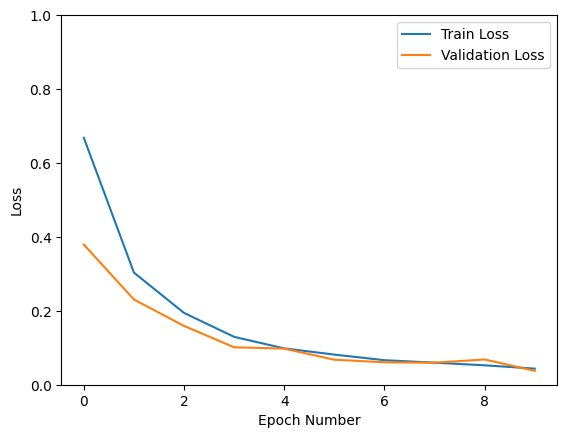

In [ ]:
history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.savefig('loss_curve.png')
plt.show()

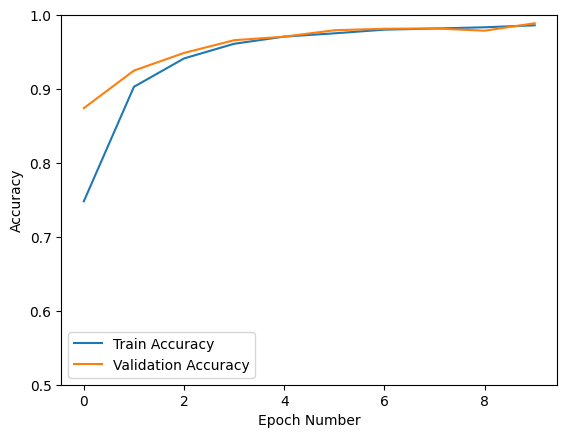

In [ ]:
plt.plot(history[:, 2:4])
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1)
plt.savefig('accuracy_curve.png')
plt.show()

In [ ]:
true_labels = []
pred_labels = []

# Функция расчета качества на тестовом датасете
def computeTestSetAccuracy(model, loss_criterion):

    test_acc = 0.0
    test_loss = 0.0

    # Валидация
    with pt.no_grad():

        model.eval()

        for j, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            outputs = outputs.squeeze(-1)

            loss = loss_criterion(outputs.float(), labels.to(pt.int64))
            test_loss += loss.item() * inputs.size(0)

            ret, predictions = pt.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            acc = pt.mean(correct_counts.type(pt.FloatTensor))
            test_acc += acc.item() * inputs.size(0)

            # Для подсчета остальных метрик в sklearn,
            # сохраним истинные и предсказанные значения
            true_labels.extend(labels.cpu().detach().numpy().astype(int).tolist())
            pred_labels.extend(predictions.cpu().detach().numpy().astype(int).tolist())

            print("Test Batch number: {:03d}, Test: Loss: {:.5f}, Accuracy: {:.5f}".format(j, loss.item(), acc.item()))

    # Находим средние loss и accuracy на тестовой выборке
    avg_test_loss = test_loss / test_data_size
    avg_test_acc = test_acc / test_data_size

    print("Test accuracy : " + str(avg_test_acc))
    print("Test loss : " + str(avg_test_loss))

In [ ]:
computeTestSetAccuracy(best_model, loss_func)

Test Batch number: 000, Test: Loss: 0.07185, Accuracy: 0.98438
Test Batch number: 001, Test: Loss: 0.00433, Accuracy: 1.00000
Test Batch number: 002, Test: Loss: 0.08570, Accuracy: 0.98438
Test Batch number: 003, Test: Loss: 0.04209, Accuracy: 0.99219
Test Batch number: 004, Test: Loss: 0.08645, Accuracy: 0.98438
Test Batch number: 005, Test: Loss: 0.01532, Accuracy: 0.99219
Test Batch number: 006, Test: Loss: 0.01857, Accuracy: 0.99219
Test Batch number: 007, Test: Loss: 0.05865, Accuracy: 0.97656
Test Batch number: 008, Test: Loss: 0.07301, Accuracy: 0.96875
Test Batch number: 009, Test: Loss: 0.04127, Accuracy: 0.98438
Test Batch number: 010, Test: Loss: 0.04429, Accuracy: 0.99219
Test Batch number: 011, Test: Loss: 0.15998, Accuracy: 0.97656
Test Batch number: 012, Test: Loss: 0.06291, Accuracy: 0.96875
Test Batch number: 013, Test: Loss: 0.07436, Accuracy: 0.97656
Test Batch number: 014, Test: Loss: 0.01910, Accuracy: 0.99219
Test Batch number: 015, Test: Loss: 0.00888, Accuracy: 

In [ ]:
# Пример выполнения предсказания моделью
# Получаем вероятности классов (надо использовать экспоненту, т.к. последний слой - LogSoftmax)
waveform, label = test_dataset[0]

def predict(model, inputs, labels):
    model.eval()
    inputs = pt.unsqueeze(inputs, 0)
    with pt.no_grad():
        out = model(inputs)
        probas = pt.exp(out)
    return probas, labels

prediction, label = predict(model,waveform,label)
print(prediction, label)

tensor([[8.0231e-06, 2.8014e-09, 2.6703e-09, 9.6794e-08, 9.9957e-01, 8.6884e-07,
         6.2389e-07, 4.2156e-04, 1.6948e-08]], device='cuda:0') 4.0


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [ ]:
print('F1: {:.5f}'.format(f1_score(true_labels, pred_labels, average="macro")))
print('Accuracy: {:.5f}'.format(accuracy_score(true_labels, pred_labels)))
print('Precision: {:.5f}'.format(precision_score(true_labels, pred_labels, average="macro")))
print('Recall: {:.5f}'.format(recall_score(true_labels, pred_labels, average="macro")))

F1: 0.97493
Accuracy: 0.98876
Precision: 0.98457
Recall: 0.96756


In [ ]:
confmat = confusion_matrix(y_true=true_labels, y_pred=pred_labels)

In [ ]:
import matplotlib.pyplot as plt

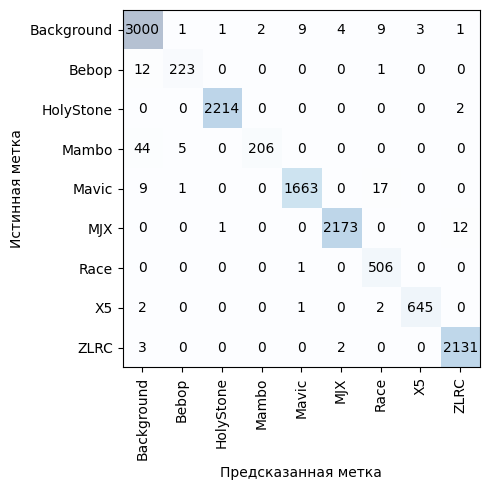

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(classes_list)), classes_list, rotation='vertical')
plt.yticks(range(len(classes_list)), classes_list)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j],
                va='center', ha='center')

ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Предсказанная метка')
plt.ylabel('Истинная метка')
plt.tight_layout()
plt.show()